## This notebook contrsucts extra spatial features of the spatiotemporal traffic dataset

## Install Required Packages
## If you haven't installed the required packages yet, please run the following command: 

In [57]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

import pandas as pd
import matplotlib.pyplot as plt


In [58]:
import seaborn as sns

AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

In [18]:
import warnings
warnings.filterwarnings('ignore')

## Before running the notebook, you should:

## 1. Manually download the file from the portal.
## 2. Place the downloaded file in the same directory as the notebook.
## 3. Run the notebook, and the above command will work without any path modifications.

## Graph nodes

In [2]:
# Read the Parquet file
node_df = pd.read_parquet("D:/TU Dortmund/Semesters/Winter Semester 2023-24/Thesis/Datasets/Traffic4Cast/road_graph/london/road_graph_nodes.parquet")

In [3]:
# Convert the node DataFrame to a GeoDataFrame with same CRS as buildings
node_gdf = gpd.GeoDataFrame(
    node_df,
    geometry=[Point(xy) for xy in zip(node_df.x, node_df.y)],
    crs="EPSG:4326" 
)

In [4]:
#Display the first five rows
node_gdf.head(5)

,node_id,counter_info,num_assigned,x,y,geometry
0,78112,,,-0.145792,51.526976,POINT (-0.14579 51.52698)
1,99936,,,-0.152791,51.523611,POINT (-0.15279 51.52361)
2,99937,,,-0.152024,51.523018,POINT (-0.15202 51.52302)
3,101818,01/285,1,-0.148104,51.535179,POINT (-0.1481 51.53518)
4,101831,02/065,1,-0.147044,51.535612,POINT (-0.14704 51.53561)


## Node Distribution Map

Visualize the spatial distribution of road graph nodes:

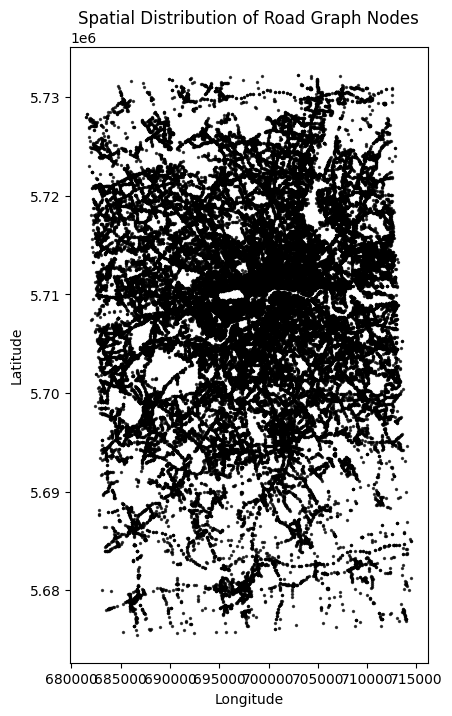

<Figure size 640x480 with 0 Axes>

In [11]:
# Plot nodes on a map
fig, ax = plt.subplots(figsize=(10, 8))
node_gdf.plot(ax=ax, markersize=2, color='black', alpha=0.7)
plt.title("Spatial Distribution of Road Graph Nodes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig('graph_nodes.png')

## Converting the node geometries into suitable UTM zone (projected CRS) for distance metric compatibility
https://epsg.io/32630

In [5]:
node_gdf = node_gdf.to_crs("EPSG:32630") 

## Reading the shapefile - buildings and their types

In [12]:
building_gdf = gpd.read_file("D:/TU Dortmund/Semesters/Winter Semester 2023-24/Thesis/Datasets/Additional modality/gis_osm_buildings_a_free_1.shp")

In [13]:
building_gdf = building_gdf.to_crs("EPSG:32630") 

In [14]:
# Print CRS values side by side
print(f"{'Dataset':<15} {'CRS':<30}")
print("=" * 50)
print(f"{'Node_GDF':<15} {str(node_gdf.crs):<30}")
print(f"{'Building_GDF':<15} {str(building_gdf.crs):<30}")


Dataset         CRS                           
Node_GDF        EPSG:32630                    
Building_GDF    EPSG:32630                    


In [15]:
building_gdf['building_area'] = building_gdf.area

In [16]:
building_gdf.head(5)

,osm_id,code,fclass,name,type,geometry,building_area
0,2956186,1500,building,Laurence House,block,"POLYGON ((706962.574 5703475.073, 706962.654 5...",1766.565888
1,2956187,1500,building,Lewisham Town Hall,None,"POLYGON ((706952.165 5703517.791, 706965.674 5...",2569.332306
2,2956188,1500,building,Broadway Theatre,None,"POLYGON ((707029.568 5703570.508, 707031.488 5...",1443.920899
3,2956192,1500,building,JD Sports,store,"POLYGON ((707147.399 5703484.689, 707147.542 5...",754.386224
4,2956193,1500,building,Air Thrill,store,"POLYGON ((707193.4 5703530.462, 707203.951 570...",2622.735734


## Unique building types

In [17]:
# Extract unique building types
unique_types = building_gdf['type'].unique()

# Set number of columns for display
num_columns = 5  

# Print in a structured format
for i, item in enumerate(unique_types, 1):
    print(f"{str(item):<25}", end="\t")  # Adjust width as needed
    if i % num_columns == 0:
        print()  # New line after every 'num_columns' items

# Ensure the last row is printed properly
print()


block                    	None                     	store                    	apartments               	warehouse                	
church                   	commercial               	supermarket              	office                   	train_station            	
stadium                  	retail                   	shop                     	school                   	hall                     	
depot                    	detached                 	hangar                   	cinema                   	parking                  	
government               	greenhouse               	laboratory               	university               	orangery                 	
pagoda                   	residential              	stable                   	hospital                 	industrial               	
pavilion                 	pier                     	transportation           	place_of_worship         	factory                  	
ship                     	tower                    	sports_centre            	terra

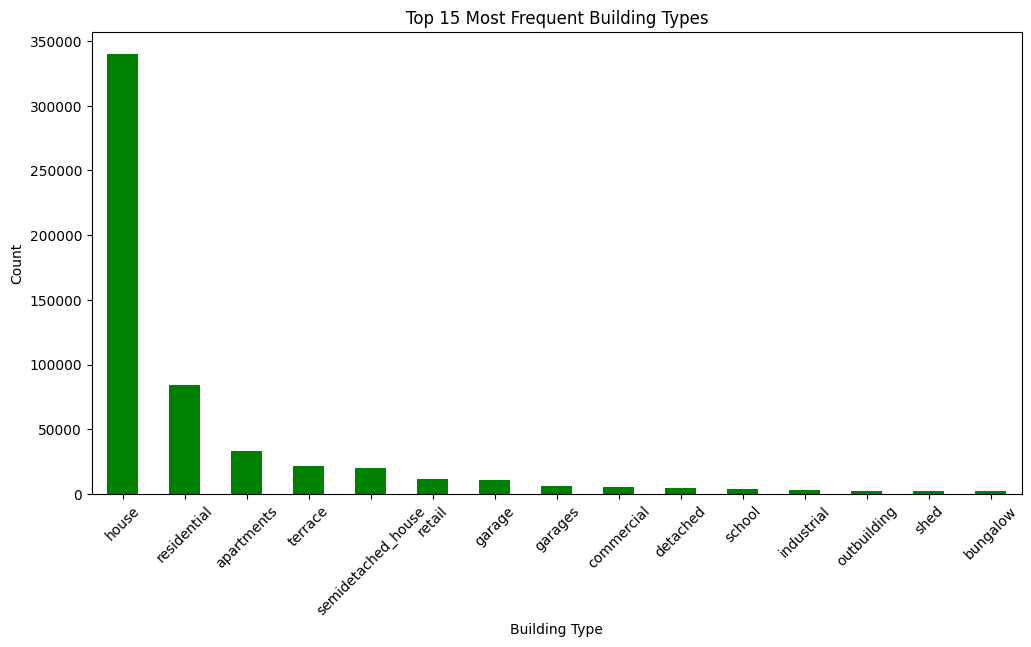

<Figure size 640x480 with 0 Axes>

In [21]:
# Extract building types (filter out '0' and 'None')
all_types = [
    item 
    for sublist in building_gdf['type'] 
    for item in (sublist if isinstance(sublist, list) else [sublist])  # Handle non-list entries
    if item not in [0, None, 'None', 'none']
]

# Proceed with plotting
type_counts = pd.Series(all_types).value_counts().head(15)

plt.figure(figsize=(12, 6))
type_counts.plot(kind='bar', color='green')
plt.title("Top 15 Most Frequent Building Types")
plt.xlabel("Building Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()
plt.savefig('type_freq.png')

## Spatial join

In [22]:
# Apply a buffer of 50 meters to each node to define the search area
node_gdf['buffered'] = node_gdf.buffer(50)

# Use the buffered geometry for spatial join
# It's important to use the buffered geometry column for the spatial operation
node_gdf.set_geometry('buffered', inplace=True)

# Perform the spatial join to find buildings within 50 meters of each node
# Changing how="left" to ensure all nodes are kept
joined_gdf_utm = gpd.sjoin(node_gdf, building_gdf, how="left", predicate="intersects")

#Reset geometry to original points for any further operations or plotting
node_gdf.set_geometry('geometry', inplace=True)

In [23]:
joined_gdf_utm = joined_gdf_utm.drop(['index_right', 'osm_id', 'code',	'fclass', 'name'], axis=1)

In [24]:
# Fill NaN values in 'building_area' with zero
joined_gdf_utm['building_area'] = joined_gdf_utm['building_area'].fillna(0)

In [25]:
joined_gdf_utm['type'] = joined_gdf_utm['type'].fillna(0)

In [26]:
joined_gdf_utm.head(5)

,node_id,counter_info,num_assigned,x,y,geometry,buffered,type,building_area
0,78112,,,-0.145792,51.526976,POINT (697982.941 5712291.401),"POLYGON ((698032.941 5712291.401, 698032.701 5...",apartments,1672.788399
0,78112,,,-0.145792,51.526976,POINT (697982.941 5712291.401),"POLYGON ((698032.941 5712291.401, 698032.701 5...",house,106.440682
0,78112,,,-0.145792,51.526976,POINT (697982.941 5712291.401),"POLYGON ((698032.941 5712291.401, 698032.701 5...",house,75.675525
0,78112,,,-0.145792,51.526976,POINT (697982.941 5712291.401),"POLYGON ((698032.941 5712291.401, 698032.701 5...",house,93.788208
0,78112,,,-0.145792,51.526976,POINT (697982.941 5712291.401),"POLYGON ((698032.941 5712291.401, 698032.701 5...",house,113.692287


## Aggregating all the buildings into a list for each unique node

In [27]:
# Group by 'node_id' and aggregate
aggregated_df = joined_gdf_utm.groupby('node_id').agg({
    'counter_info': 'first',
    'num_assigned': 'first',
    'x': 'first',
    'y': 'first',
    'geometry': 'first',
    'buffered': 'first',
    'type': lambda x: list(x),
    'building_area': lambda x: list(x)
}).reset_index()

In [28]:
# Convert the result back to a GeoDataFrame if necessary
aggregated_gdf = gpd.GeoDataFrame(aggregated_df, geometry='geometry')

In [29]:
aggregated_gdf.head(5)

,node_id,counter_info,num_assigned,x,y,geometry,buffered,type,building_area
0,78112,,,-0.145792,51.526976,POINT (697982.941 5712291.401),"POLYGON ((698032.941 5712291.401, 698032.701 5...","[apartments, house, house, house, house, house...","[1672.788399360193, 106.44068181519721, 75.675..."
1,99936,,,-0.152791,51.523611,POINT (697512.168 5711898.305),"POLYGON ((697562.168 5711898.305, 697561.928 5...","[apartments, university, university, 0, no, un...","[602.8819213738892, 654.8602955672661, 83.4488..."
2,99937,,,-0.152024,51.523018,POINT (697567.94 5711834.457),"POLYGON ((697617.94 5711834.457, 697617.699 57...","[church, university, 0, commercial, university...","[1105.9177423975038, 654.8602955672661, 46.521..."
3,101818,01/285,1,-0.148104,51.535179,POINT (697787.069 5713197.146),"POLYGON ((697837.069 5713197.146, 697836.829 5...","[0, house, 0, terrace]","[40.76653224844853, 65.52455626695391, 49.1898..."
4,101831,02/065,1,-0.147044,51.535612,POINT (697858.692 5713248.145),"POLYGON ((697908.692 5713248.145, 697908.451 5...","[detached, 0, detached, 0]","[63.21064710270548, 225.06906974589083, 287.39..."


## Constructing new features 

## Building Density

In [30]:
# Calculate building density (number of buildings per unit area)
# Building density in this context is defined as the number of buildings per unit area (e.g., buildings per square meter).
aggregated_gdf['building_density'] = aggregated_gdf['building_area'].apply(len) / aggregated_gdf['buffered'].area

In [31]:
# Normalize the building density
min_density = aggregated_gdf['building_density'].min()
max_density = aggregated_gdf['building_density'].max()
aggregated_gdf['building_density'] = (aggregated_gdf['building_density'] - min_density) / (max_density - min_density)

In [32]:
aggregated_gdf[['node_id', 'type', 'building_area', 'building_density']].head(5)

,node_id,type,building_area,building_density
0,78112,"[apartments, house, house, house, house, house...","[1672.788399360193, 106.44068181519721, 75.675...",0.079545
1,99936,"[apartments, university, university, 0, no, un...","[602.8819213738892, 654.8602955672661, 83.4488...",0.079545
2,99937,"[church, university, 0, commercial, university...","[1105.9177423975038, 654.8602955672661, 46.521...",0.079545
3,101818,"[0, house, 0, terrace]","[40.76653224844853, 65.52455626695391, 49.1898...",0.034091
4,101831,"[detached, 0, detached, 0]","[63.21064710270548, 225.06906974589083, 287.39...",0.034091


## Building Density Distribution

Histogram of normalized building density:

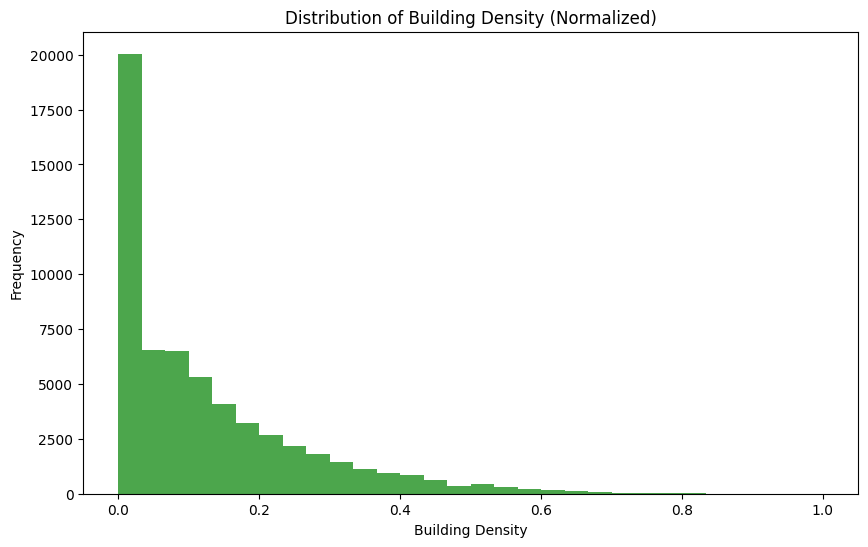

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(aggregated_gdf['building_density'], bins=30, color='green', alpha=0.7)
plt.title("Distribution of Building Density (Normalized)")
plt.xlabel("Building Density")
plt.ylabel("Frequency")
plt.show()
plt.savefig('density_dist.png')

The distribution of the nodes sorrounding the building area are skewed. Y - axis display the number of nodes and the x - axis shows the normalized building density. It can be seen that most of the nodes reside in the low-density areas, meaning to the left.

## Building Type Diversity

In [35]:
# Calculate the diversity of building types
aggregated_gdf['building_type_diversity'] = aggregated_gdf['type'].apply(lambda types: len(set(types)))

In [36]:
aggregated_gdf[['node_id', 'type', 'building_type_diversity']].head(5)

,node_id,type,building_type_diversity
0,78112,"[apartments, house, house, house, house, house...",2
1,99936,"[apartments, university, university, 0, no, un...",5
2,99937,"[church, university, 0, commercial, university...",5
3,101818,"[0, house, 0, terrace]",3
4,101831,"[detached, 0, detached, 0]",2


## Location Type Composition

Pie chart of location types:

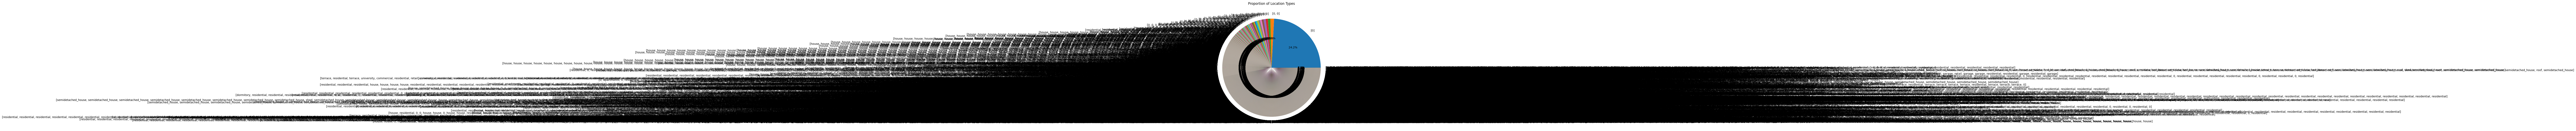

<Figure size 640x480 with 0 Axes>

In [40]:
location_counts = aggregated_gdf['type'].value_counts()
plt.figure(figsize=(8, 8))
location_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title("Proportion of Location Types")
plt.ylabel("")
plt.show()
plt.savefig('loc_type.png')

## Presence of Key Building Types

In [42]:
# Define the array of building types
building_types = ['apartments', 'commercial', 'supermarket', 'office', 'train_station', 'stadium',
                  'school', 'cinema', 'parking', 'government', 'university',  'residential', 
                  'hospital', 'industrial', 'factory',  'sports_centre', 'hotel', 'flats', 'house', 
                  'college',  'shopping_centre', 'theatre', 'central_office', 'dormitory', 
                  'community_centre', 'fire_station', 'kindergarten', 'museum', 'mall', 'school_hostel',  'pub', 'public_building',
                  'university', 'restaurant', 'bus_station', 'car_park']

# Create new columns for each building type
for building_type in building_types:
    col_name = f'has_{building_type}'
    aggregated_gdf[col_name] = aggregated_gdf['type'].apply(lambda x: 1 if building_type in x else 0)

In [43]:
aggregated_gdf.head(5)

,node_id,counter_info,num_assigned,x,y,geometry,buffered,type,building_area,building_density,...,has_fire_station,has_kindergarten,has_museum,has_mall,has_school_hostel,has_pub,has_public_building,has_restaurant,has_bus_station,has_car_park
0,78112,,,-0.145792,51.526976,POINT (697982.941 5712291.401),"POLYGON ((698032.941 5712291.401, 698032.701 5...","[apartments, house, house, house, house, house...","[1672.788399360193, 106.44068181519721, 75.675...",0.079545,...,0,0,0,0,0,0,0,0,0,0
1,99936,,,-0.152791,51.523611,POINT (697512.168 5711898.305),"POLYGON ((697562.168 5711898.305, 697561.928 5...","[apartments, university, university, 0, no, un...","[602.8819213738892, 654.8602955672661, 83.4488...",0.079545,...,0,0,0,0,0,0,0,0,0,0
2,99937,,,-0.152024,51.523018,POINT (697567.94 5711834.457),"POLYGON ((697617.94 5711834.457, 697617.699 57...","[church, university, 0, commercial, university...","[1105.9177423975038, 654.8602955672661, 46.521...",0.079545,...,0,0,0,0,0,0,0,0,0,0
3,101818,01/285,1,-0.148104,51.535179,POINT (697787.069 5713197.146),"POLYGON ((697837.069 5713197.146, 697836.829 5...","[0, house, 0, terrace]","[40.76653224844853, 65.52455626695391, 49.1898...",0.034091,...,0,0,0,0,0,0,0,0,0,0
4,101831,02/065,1,-0.147044,51.535612,POINT (697858.692 5713248.145),"POLYGON ((697908.692 5713248.145, 697908.451 5...","[detached, 0, detached, 0]","[63.21064710270548, 225.06906974589083, 287.39...",0.034091,...,0,0,0,0,0,0,0,0,0,0


## Spatial Heatmap of Key Building Types

Example: Presence of schools:

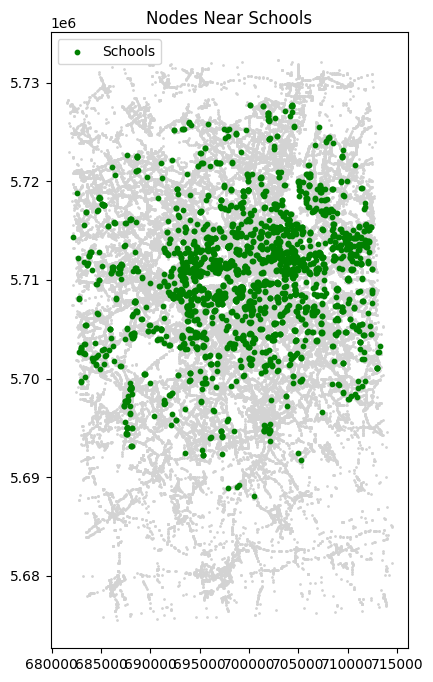

In [51]:
# Filter nodes with schools
school_nodes = aggregated_gdf[aggregated_gdf['has_school'] == 1]

fig, ax = plt.subplots(figsize=(10, 8))
aggregated_gdf.plot(ax=ax, color='lightgray', markersize=1)
school_nodes.plot(ax=ax, color='green', markersize=10, label='Schools')
plt.title("Nodes Near Schools")
plt.legend()
plt.show()

## Location type

In [52]:
# Define function to determine location type
def determine_location_type(row):
    if row['has_residential'] and row['has_commercial']:
        return 'Mixed'
    elif row['has_residential']:
        return 'Residential'
    elif row['has_commercial']:
        return 'Commercial'
    elif row['has_school'] or row['has_university']:
        return 'Educational'
    elif row['has_hospital']:
        return 'Healthcare'
    elif row['has_industrial'] or row['has_factory']:
        return 'Industrial'
    else:
        return 'Other'

In [53]:
# Apply function to create new column 'location_type'
aggregated_gdf['location_type'] = aggregated_gdf.apply(determine_location_type, axis=1)

In [54]:
aggregated_gdf[['node_id', 'type', 'location_type']].head(5)

,node_id,type,location_type
0,78112,"['apartments', 'house', 'house', 'house', 'hou...",Other
1,99936,"['apartments', 'university', 'university', 0, ...",Educational
2,99937,"['church', 'university', 0, 'commercial', 'uni...",Commercial
3,101818,"[0, 'house', 0, 'terrace']",Other
4,101831,"['detached', 0, 'detached', 0]",Other


## Building Area vs. Location Type

Boxplot comparing building areas across location types:

In [55]:
# Flatten building areas
area_data = aggregated_gdf.explode('building_area')
area_data['building_area'] = area_data['building_area'].astype(float)

plt.figure(figsize=(12, 6))
sns.boxplot(x='location_type', y='building_area', data=area_data)
plt.title("Building Area Distribution by Location Type")
plt.xticks(rotation=45)
plt.yscale('log')  # Use log scale if outliers exist
plt.show()
plt.savefig('area_loc.png')

NameError: name 'sns' is not defined

<Figure size 1200x600 with 0 Axes>

## Saving the node file with extra features as parquet file

In [49]:
aggregated_gdf["type"] = aggregated_gdf["type"].astype(str)
aggregated_gdf.to_parquet("road_graph_nodes_FE.parquet", engine="pyarrow")

In [53]:
file_path = "road_graph_nodes_FE.parquet"

In [55]:
check_gdf = pd.read_parquet(file_path)

In [56]:
check_gdf.head(5)

,node_id,counter_info,num_assigned,x,y,geometry,buffered,type,building_area,building_density,...,has_kindergarten,has_museum,has_mall,has_school_hostel,has_pub,has_public_building,has_restaurant,has_bus_station,has_car_park,location_type
0,78112,,,-0.145792,51.526976,b'\x01\x01\x00\x00\x00\x90\xcc\x08\xe2\xfdL%AX...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00A\x00\x0...,"['apartments', 'house', 'house', 'house', 'hou...","[1672.788399360193, 106.44068181519721, 75.675...",0.079545,...,0,0,0,0,0,0,0,0,0,Other
1,99936,,,-0.152791,51.523611,b'\x01\x01\x00\x00\x00F\xadBVPI%A\xfa%\x8b\x93...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00A\x00\x0...,"['apartments', 'university', 'university', 0, ...","[602.8819213738892, 654.8602955672661, 83.4488...",0.079545,...,0,0,0,0,0,0,0,0,0,Educational
2,99937,,,-0.152024,51.523018,b'\x01\x01\x00\x00\x00\x8eFB\xe1\xbfI%A\xc0n=\...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00A\x00\x0...,"['church', 'university', 0, 'commercial', 'uni...","[1105.9177423975038, 654.8602955672661, 46.521...",0.079545,...,0,0,0,0,0,0,0,0,0,Commercial
3,101818,01/285,1,-0.148104,51.535179,b'\x01\x01\x00\x00\x00\xc4\xed\x7f#vK%AIEZIK\x...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00A\x00\x0...,"[0, 'house', 0, 'terrace']","[40.76653224844853, 65.52455626695391, 49.1898...",0.034091,...,0,0,0,0,0,0,0,0,0,Other
4,101831,02/065,1,-0.147044,51.535612,b'\x01\x01\x00\x00\x00\x8f\x16\x0fb\x05L%A\x7f...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00A\x00\x0...,"['detached', 0, 'detached', 0]","[63.21064710270548, 225.06906974589083, 287.39...",0.034091,...,0,0,0,0,0,0,0,0,0,Other
